<a href="https://colab.research.google.com/github/Parkjoonhyeong/Clerk1/blob/main/0419_GraphCodeBERT_%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install transformers
!pip install tokenizers
!pip install pandas
!pip install torch
!pip install tqdm
!pip install scikit-learn
!pip install easydict

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer
from tqdm.auto import tqdm
import logging
from torch.utils.data import DataLoader, SequentialSampler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, RandomSampler
from torch.optim import AdamW  # torch.optim에서 AdamW를 직접 가져오기
from transformers import get_linear_schedule_with_warmup
import os
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel
import pickle
from easydict import EasyDict as edict
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

In [22]:
# 로깅 설정을 먼저 수행
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# 로거 인스턴스를 생성
logger = logging.getLogger(__name__)

In [47]:
# 인자 설정 클래스
args = edict({
    'train_data_file': '/content/drive/MyDrive/final_train5.csv',
    'eval_data_file': '/content/drive/MyDrive/final_val2.csv',
    'test_data_file': '/content/drive/MyDrive/final_test.csv',
    'output_dir': '/content/drive/My Drive/output',
    'model_name_or_path': 'microsoft/graphcodebert-base',
    'tokenizer_name': 'microsoft/graphcodebert-base',
    'block_size': 512,
    'use_logit_adjustment': False,
    'tau': 1.2,
    'model_type': 'bert',
    'code_length': 256,
    'do_train': True,
    'do_eval': True,
    'do_test': True,
    'evaluate_during_training': False,
    'do_local_explanation': False,
    'reasoning_method': None,
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'learning_rate': 3e-5,
    'weight_decay': 0.01,
    'adam_epsilon': 1e-8,
    'max_grad_norm': 1.0,
    'max_steps': -1,
    'warmup_steps': 500,
    'seed': 42,
    'epochs': 5,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    'n_gpu': 1,
    'cwe_label_map': {
         "0" : 0,
         "1": 1,
         "2": 2,
         "3": 3,
      "4": 4,
    "5": 5,
    "6": 6,
    "7": 7,
    "8": 8,
    "9": 9,
    "10": 10
    }
})

In [48]:
# 토크나이저 설정
tokenizer = RobertaTokenizer.from_pretrained(args.tokenizer_name)

In [49]:
# InputFeatures 클래스 정의
class InputFeatures:
    """데이터의 한 세트의 특성을 정의합니다."""
    def __init__(self, input_ids, attention_mask, cwe_type_label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.cwe_type_label = cwe_type_label


In [50]:
# 특성 변환 함수
def convert_examples_to_features(func, cwe_type_label, tokenizer, max_length):
    """코드 스니펫을 모델 입력에 적합한 특성으로 변환합니다."""
    encoding = tokenizer.encode_plus(
        text=func,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    return InputFeatures(
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        cwe_type_label=cwe_type_label
    )

In [54]:
from tqdm.auto import tqdm

class TextDataset(Dataset):
    def __init__(self, tokenizer, args, cwe_label_map, file_type="train"):
        self.tokenizer = tokenizer
        self.cwe_label_map = args.cwe_label_map
        file_path = getattr(args, f"{file_type}_data_file")
        self.examples = []
        df = pd.read_csv(file_path)
        funcs = df["code"].tolist()
        cwe_type_labels = df["labels"].tolist()

        for func, label in tqdm(zip(funcs, cwe_type_labels), total=len(funcs), desc="Loading data"):
            cwe_type_label = self.cwe_label_map.get(label, 0)
            features = convert_examples_to_features(func, cwe_type_label, tokenizer, args.block_size)
            self.examples.append(features)


    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return {
            'input_ids': self.examples[idx].input_ids.clone().detach(),
            'attention_mask': self.examples[idx].attention_mask.clone().detach(),
            'labels': torch.tensor(self.examples[idx].cwe_type_label)
        }


In [55]:
# 데이터셋과 데이터 로더 생성
train_dataset = TextDataset(tokenizer, args, args.cwe_label_map, file_type='train')
train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

Loading data:   0%|          | 0/13415 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [56]:


def compute_adjustment(tau, args, cwe_label_map):
    """클래스 빈도에 따라 로짓 조정 값을 계산합니다.

    Args:
        tau (float): 조정 계수, 클래스 빈도의 지수화에 사용됩니다.
        args (Args class): 설정 정보를 담고 있는 클래스 인스턴스.
        cwe_label_map (dict): 각 CWE ID에 대한 [index, one_hot, frequency] 정보를 담은 사전.

    Returns:
        torch.Tensor: 조정된 로짓 값들이 담긴 텐서.
    """
    # 빈도 수집: 사전 순서대로 빈도를 배열에 저장
    freq = [v[2] for k, v in sorted(cwe_label_map.items(), key=lambda item: item[1][0])]

    # 레이블 빈도를 PyTorch 텐서로 변환하고 정규화
    label_freq_tensor = torch.tensor(freq, dtype=torch.float32, device=args.device)
    label_freq_tensor /= label_freq_tensor.sum()

    # 로짓 조정 계산
    adjustments = torch.log(torch.pow(label_freq_tensor, tau) + 1e-12)

    return adjustments


In [57]:
def compute_adjustment(tau, args, cwe_label_map):
    """클래스 빈도에 따라 로짓 조정 값을 계산합니다.

    Args:
        tau (float): 조정 계수, 클래스 빈도의 지수화에 사용됩니다.
        args (Args class): 설정 정보를 담고 있는 클래스 인스턴스.
        cwe_label_map (dict): 각 CWE ID에 대한 [index, one_hot, frequency] 정보를 담은 사전.

    Returns:
        torch.Tensor: 조정된 로짓 값들이 담긴 텐서.
    """
    # 빈도 수집: 사전 순서대로 빈도를 배열에 저장
    freq = [v[2] for k, v in sorted(cwe_label_map.items(), key=lambda item: item[1][0])]

    # 레이블 빈도를 PyTorch 텐서로 변환하고 정규화
    label_freq_tensor = torch.tensor(freq, dtype=torch.float32, device=args.device)
    label_freq_tensor /= label_freq_tensor.sum()

    # 로짓 조정 계산
    adjustments = torch.log(torch.pow(label_freq_tensor, tau) + 1e-12)

    return adjustments

In [58]:
import random

def set_seed(args):
    """
    모든 난수 생성기의 시드를 설정하여 실험의 재현성을 보장합니다.

    Args:
    - args (Args class): 시드와 GPU 사용 여부를 포함하는 설정 클래스 인스턴스.

    이 함수는 Python의 내장 난수 생성기, NumPy, 그리고 PyTorch에 대해 동일한 시드를 설정합니다.
    또한, 여러 GPU를 사용하는 경우 각 디바이스의 CUDA 난수 생성기에 대해서도 시드를 설정합니다.
    """
    random.seed(args.seed)  # Python 내장 난수 생성기의 시드 설정
    np.random.seed(args.seed)  # NumPy 난수 생성기의 시드 설정
#    torch.manual_seed(args.seed)  # PyTorch 난수 생성기의 시드 설정

#    # CUDA 난수 생성기의 시드 설정 (GPU 사용 시)
#    if args.n_gpu > 0:
#        torch.cuda.manual_seed_all(args.seed)

# 예시로 Args 클래스를 정의하고 seed와 n_gpu를 설정합니다.
#class Args:
#    seed = 42
#    n_gpu = 1  # 이 값을 Colab에서 사용할 GPU 수에 맞춰 설정하세요.

#args = Args()
#set_seed(args)  # 시드 설정 함수 호출


In [59]:
from tqdm.auto import tqdm  # 상단에 라이브러리 임포트

def train(args, train_dataset, model, tokenizer, eval_dataset):
    optimizer = AdamW(model.parameters(), lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=args.max_steps)
    model.to(args.device)
    model.train()

    best_loss = float('inf')  # 최적 손실 초기화 - 함수 시작 부분에서 초기화

    train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)

    for epoch in range(args.epochs):
        logger.info(f"Starting Epoch {epoch + 1}/{args.epochs}")
        total_loss = 0
        for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")):
            batch = {k: v.to(args.device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            if args.n_gpu > 1:
                loss = loss.mean()  # 멀티 GPU 사용 시
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            total_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

        if eval_dataset is not None:
            eval_result = evaluate(args, model, tokenizer, eval_dataset)
            eval_loss = eval_result['eval_total_loss']
            logger.info(f"Epoch {epoch + 1} Evaluation Loss: {eval_loss:.4f}")

            # 로스 감소 시 체크포인트 저장
            if eval_loss < best_loss:
                best_loss = eval_loss  # 오류 발생 지점
                save_checkpoint(model, args.output_dir, 'best_model.pt')

    logger.info("Training complete.")


In [60]:
def evaluate(args, model, tokenizer, eval_dataset, eval_when_training=False):
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, num_workers=0)

    model.eval()
    total_loss = 0
    total_examples = 0

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        batch = {k: v.to(args.device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            total_examples += batch['input_ids'].size(0)

    avg_loss = total_loss / total_examples
    logger.info(f"Total evaluation loss: {avg_loss:.4f}")
    return {'eval_total_loss': avg_loss}


In [61]:
logger = logging.getLogger(__name__)

def test(args, model, tokenizer, test_dataset, best_threshold=0.5):
    # DataLoader 구성
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=args.eval_batch_size, num_workers=0)

    # 다중 GPU 설정
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # 모델 평가 모드 설정
    model.eval()
    logger.info("***** Running Test *****")
    logger.info("Num examples = %d", len(test_dataset))
    logger.info("Batch size = %d", args.eval_batch_size)

    # 예측 및 실제 레이블 저장용 리스트
    cwe_type_preds = []
    cwe_type_trues = []

    # 테스트 데이터에 대한 평가
    for batch in test_dataloader:
        batch = {k: v.to(args.device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            cwe_type_preds.extend(predictions.cpu().numpy())
            cwe_type_trues.extend(batch['labels'].cpu().numpy())

    # 정확도 계산
    cwe_type_acc = accuracy_score(cwe_type_trues, cwe_type_preds)
    result_cwe = {"CWE Type Accuracy": cwe_type_acc}

    # 결과 로깅
    logger.info("***** CWE Type Classification Test Results *****")
    for key, value in result_cwe.items():
        logger.info(f"{key} = {value:.4f}")

    return result_cwe


In [62]:
# 설정된 디바이스와 GPU 정보 출력
logger.info(f"Device: {args.device}, Number of GPUs: {args.n_gpu}")

# Random seed 설정
#set_seed(args)

# Load tokenizers and models
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(
    args.model_name_or_path,
    num_labels=11  # CWE 유형의 수, num_cwe_types 대신 명시적으로 11 사용
)
model.to(args.device)

# 데이터셋 로드
train_dataset = TextDataset(tokenizer, args, args.cwe_label_map, file_type='train')
eval_dataset = TextDataset(tokenizer, args, args.cwe_label_map, file_type='eval')
test_dataset = TextDataset(tokenizer, args, args.cwe_label_map, file_type='test')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading data:   0%|          | 0/13415 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Loading data:   0%|          | 0/5749 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Loading data:   0%|          | 0/480 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [63]:
# 훈련과 평가 실행
if args.do_train:
    logger.info("Starting training...")
    train(args, train_dataset, model, tokenizer, eval_dataset)

Epoch 1 Training:   0%|          | 0/1677 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/719 [00:00<?, ?it/s]

Epoch 2 Training:   0%|          | 0/1677 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/719 [00:00<?, ?it/s]

Epoch 3 Training:   0%|          | 0/1677 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/719 [00:00<?, ?it/s]

Epoch 4 Training:   0%|          | 0/1677 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/719 [00:00<?, ?it/s]

Epoch 5 Training:   0%|          | 0/1677 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/719 [00:00<?, ?it/s]

In [64]:
if args.do_eval:
    logger.info("Starting evaluation...")
    evaluate(args, model, tokenizer, eval_dataset, eval_when_training=False)

Evaluating:   0%|          | 0/719 [00:00<?, ?it/s]

In [65]:
if args.do_test:
    logger.info("Starting testing...")
    test(args, model, tokenizer, test_dataset, best_threshold=0.5)

In [66]:
!pip install matplotlib seaborn scikit-learn

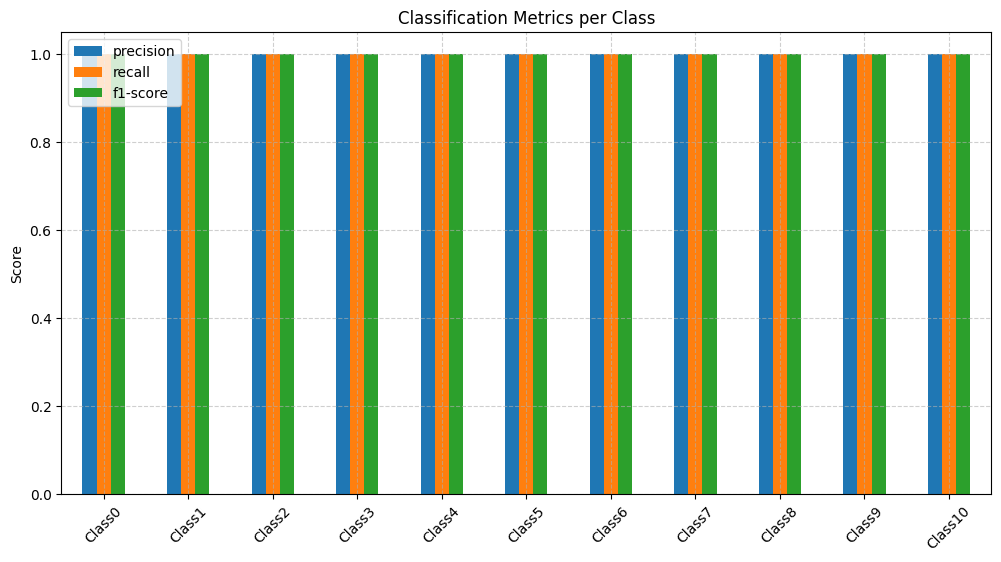

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np

def plot_classification_metrics(y_true, y_pred, class_names):
    # Classification report를 딕셔너리 형태로 계산
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # DataFrame으로 변환
    df_report = pd.DataFrame(report).transpose()

    # 마지막 행은 전체 평균이므로 제외
    df_report = df_report[:-3]  # 'accuracy' row 제외, 마지막 세 행 제거(macro avg, weighted avg 포함)

    # 막대 그래프로 표시
    df_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
    plt.title('Classification Metrics per Class')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper left')
    plt.show()

# 예시 실행 코드
# class_names는 데이터셋의 클래스 레이블 이름 리스트입니다.
class_names = ['Class0', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10']
y_true = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # 실제 레이블
y_pred = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # 예측 레이블

# 시각화 함수 호출
plot_classification_metrics(y_true, y_pred, class_names)
